# Creating a Laguna Seca Lap Time predictor

Honestly there was little data for that I can get in so bear with me on this one

In [2]:
%pip install numpy
%pip install pandas
%pip install scikit-learn==1.2.2
%pip install matplotlib
%pip install seaborn
%pip install graphviz
%sudo port install viz
%pip install mlxtend
%pip install pydotplus


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgr

UsageError: Line magic function `%sudo` not found.


## Data Preparation

In [3]:
import numpy as np
import pandas as pd
# Modules used for Data Setup
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Modules for Regression Models
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
# Metric Measurements
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, get_scorer_names
# Pyplot measurements
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

svrparm = {
    "kernel": ["linear", "poly", "sigmoid", "rbf"],
    "degree": [n for n in range(1,16)],
    "C": np.logspace(-3,3,16),
    "epsilon": np.logspace(-1,1,20)
}

treeparm = {
    "criterion": ["squared_error", "friedman_mse", "absolute_error"],
    "splitter": ["best", "random"],
    "max_features": ["sqrt", "log2"],
    "max_depth": [n for n in range(1,21)]
}

knnparm = {
    "n_neighbors": [n for n in range(1,16)],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "weights": ["uniform", "distance", None],
    "leaf_size": [n for n in range(10, 51)],
    "p": [1,2,3]
}

Scoreset = {
    "Names": ["SVR", "Tree", "KNN"],
    "MAE": [],
    "MSE": [],
    "R2": []
}

In [4]:
df = pd.read_csv("LagunaSecaLapTimesMore.csv")

df

,Name,CarLink,Time,PS,Weight_KG,Car_type,Year,Country_of_Origin,Engine_type,Displacement,Transmission,Engine_Layout,Drivetrain
0,Acura ARX-01b,https://fastestlaps.com/models/acura-arx-01b,70.10,558,825,Coupe,2008.0,Japan,V8 DOHC,3.4,6 speed Sequential,middle engine,rear wheel drive
1,Porsche RS Spyder (Evo),https://fastestlaps.com/models/porsche-rs-spyder,70.35,510,775,Coupe,2007.0,Germany,V8 DOHC,3.4,6 speed Sequential,middle engine,rear wheel drive
2,Acura ARX-01a,https://fastestlaps.com/models/acura-arx-01a,70.91,558,825,Coupe,2007.0,Germany,V8 DOHC,3.4,6 speed Sequential,middle engine,rear wheel drive
3,Audi R10 TDI,https://fastestlaps.com/models/audi-r10-tdi,71.17,659,925,Coupe,2006.0,Germany,V12 DOHC Twin Turbo,5.5,5 speed Sequential,middle engine,rear wheel drive
4,Porsche RS Spyder,https://fastestlaps.com/models/porsche-rs-spyd...,74.03,487,775,Coupe,2005.0,Germany,V8 DOHC,3.0,6 speed Sequential,middle engine,rear wheel drive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,Honda NSX (facelift),https://fastestlaps.com/models/honda-nsx,117.00,290,1368,Coupe,2004.0,Japan,V6,3.2,6,middle engine,rear wheel drive
183,Porsche Boxster S (981),https://fastestlaps.com/models/porsche-boxster...,119.01,315,1400,Convertible,2012.0,Germany,boxer/6,3.4,6-speed-manual / 7-speed-PDK,middle engine,rear wheel drive
184,Chevrolet Camaro Z28,https://fastestlaps.com/models/chevrolet-camar...,125.80,193,1448,Coupe,1982.0,United States,305ci V8,5.0,5,front engine,rear wheel drive
185,Ford Mustang GT,https://fastestlaps.com/models/ford-mustang-gt...,129.90,159,1422,Coupe,1982.0,United States,5.0 V8,5.0,5,front engine,rear wheel drive


Before we start, we need to do some things

- Remove name and car link, those are the least important terms to check out
- as much as I hate to, remove engine type and transmission. I have not found a way to make that more readable.
- Get the dummies of the categoricals
- Scale the Numericals using MinMax Scaler

In [5]:
df.drop(columns = ["Name", "CarLink"], inplace = True)

df

,Time,PS,Weight_KG,Car_type,Year,Country_of_Origin,Engine_type,Displacement,Transmission,Engine_Layout,Drivetrain
0,70.10,558,825,Coupe,2008.0,Japan,V8 DOHC,3.4,6 speed Sequential,middle engine,rear wheel drive
1,70.35,510,775,Coupe,2007.0,Germany,V8 DOHC,3.4,6 speed Sequential,middle engine,rear wheel drive
2,70.91,558,825,Coupe,2007.0,Germany,V8 DOHC,3.4,6 speed Sequential,middle engine,rear wheel drive
3,71.17,659,925,Coupe,2006.0,Germany,V12 DOHC Twin Turbo,5.5,5 speed Sequential,middle engine,rear wheel drive
4,74.03,487,775,Coupe,2005.0,Germany,V8 DOHC,3.0,6 speed Sequential,middle engine,rear wheel drive
...,...,...,...,...,...,...,...,...,...,...,...
182,117.00,290,1368,Coupe,2004.0,Japan,V6,3.2,6,middle engine,rear wheel drive
183,119.01,315,1400,Convertible,2012.0,Germany,boxer/6,3.4,6-speed-manual / 7-speed-PDK,middle engine,rear wheel drive
184,125.80,193,1448,Coupe,1982.0,United States,305ci V8,5.0,5,front engine,rear wheel drive
185,129.90,159,1422,Coupe,1982.0,United States,5.0 V8,5.0,5,front engine,rear wheel drive


In [6]:
numericals = df[["Year","Time", "PS", "Weight_KG", "Displacement"]]

numericals

,Year,Time,PS,Weight_KG,Displacement
0,2008.0,70.10,558,825,3.4
1,2007.0,70.35,510,775,3.4
2,2007.0,70.91,558,825,3.4
3,2006.0,71.17,659,925,5.5
4,2005.0,74.03,487,775,3.0
...,...,...,...,...,...
182,2004.0,117.00,290,1368,3.2
183,2012.0,119.01,315,1400,3.4
184,1982.0,125.80,193,1448,5.0
185,1982.0,129.90,159,1422,5.0


In [7]:
cartypedummies = pd.get_dummies(data = df["Car_type"], prefix = "CarType")

countrydummies = pd.get_dummies(data = df["Country_of_Origin"], prefix = "Country")

layoutdummies = pd.get_dummies(data = df["Engine_Layout"], prefix = "Layout")

drivedummies = pd.get_dummies(data = df["Drivetrain"], prefix = "Drive")

In [8]:
newdf = numericals.join(cartypedummies)

newdf = newdf.join(countrydummies)

newdf = newdf.join(layoutdummies)

newdf = newdf.join(drivedummies)

newdf

,Year,Time,PS,Weight_KG,Displacement,CarType_4-door saloon,CarType_Compact,CarType_Convertible,CarType_Coupe,CarType_Estate/wagon,...,Country_Japan,Country_South Korea,Country_United Kingdom,Country_United States,Layout_front engine,Layout_middle engine,Layout_rear engine,Drive_all wheel drive,Drive_front wheel drive,Drive_rear wheel drive
0,2008.0,70.10,558,825,3.4,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,1
1,2007.0,70.35,510,775,3.4,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
2,2007.0,70.91,558,825,3.4,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
3,2006.0,71.17,659,925,5.5,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
4,2005.0,74.03,487,775,3.0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,2004.0,117.00,290,1368,3.2,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,1
183,2012.0,119.01,315,1400,3.4,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
184,1982.0,125.80,193,1448,5.0,0,0,0,1,0,...,0,0,0,1,1,0,0,0,0,1
185,1982.0,129.90,159,1422,5.0,0,0,0,1,0,...,0,0,0,1,1,0,0,0,0,1


In [9]:
elscalo = MinMaxScaler()

fitter = elscalo.fit(newdf)

fitment = fitter.transform(newdf)

scaleddf = pd.DataFrame(fitment, columns = newdf.columns)

scaleddf

,Year,Time,PS,Weight_KG,Displacement,CarType_4-door saloon,CarType_Compact,CarType_Convertible,CarType_Coupe,CarType_Estate/wagon,...,Country_Japan,Country_South Korea,Country_United Kingdom,Country_United States,Layout_front engine,Layout_middle engine,Layout_rear engine,Drive_all wheel drive,Drive_front wheel drive,Drive_rear wheel drive
0,0.763636,0.000000,0.368655,0.032031,0.404762,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.745455,0.003996,0.325913,0.000000,0.404762,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.745455,0.012946,0.368655,0.032031,0.404762,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.727273,0.017101,0.458593,0.096092,0.654762,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.709091,0.062810,0.305432,0.000000,0.357143,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,0.690909,0.749560,0.130009,0.379885,0.380952,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
183,0.836364,0.781685,0.152271,0.400384,0.404762,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
184,0.290909,0.890203,0.043633,0.431134,0.595238,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
185,0.290909,0.955730,0.013357,0.414478,0.595238,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


We can now split our data.

In [10]:
x = scaleddf.drop(columns="Time")
y = scaleddf["Time"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=42)

## Optimizing and fitting the models

### SVR

In [11]:
svthing = SVR()

svcv = GridSearchCV(estimator=svthing, param_grid= svrparm, cv = 10)

svcv.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=SVR(),
             param_grid={'C': array([1.00000000e-03, 2.51188643e-03, 6.30957344e-03, 1.58489319e-02,
       3.98107171e-02, 1.00000000e-01, 2.51188643e-01, 6.30957344e-01,
       1.58489319e+00, 3.98107171e+00, 1.00000000e+01, 2.51188643e+01,
       6.30957344e+01, 1.58489319e+02, 3.98107171e+02, 1.00000000e+03]),
                         'degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                    14, 15],
                         'epsilon': array([ 0.1       ,  0.1274275 ,  0.16237767,  0.20691381,  0.26366509,
        0.33598183,  0.42813324,  0.54555948,  0.6951928 ,  0.88586679,
        1.12883789,  1.43844989,  1.83298071,  2.33572147,  2.97635144,
        3.79269019,  4.83293024,  6.15848211,  7.8475997 , 10.        ]),
                         'kernel': ['linear', 'poly', 'sigmoid', 'rbf']})

In [12]:
svcv.best_estimator_

SVR(C=398.1071705534977, degree=1, kernel='linear')

In [13]:
y_hat = svcv.predict(x_test)

print(f"Abs Error: {mean_absolute_error(y_test, y_hat)}")
print(f"Square Error: {mean_squared_error(y_test, y_hat)}")
print(f"r2_score: {r2_score(y_test, y_hat)}")

Scoreset["MAE"].append(mean_absolute_error(y_test, y_hat))
Scoreset["MSE"].append(mean_squared_error(y_test, y_hat))
Scoreset["R2"].append(r2_score(y_test, y_hat))

Scoreset


Abs Error: 0.06483634862354092
Square Error: 0.011398105781102645
r2_score: 0.39487121109227763


{'Names': ['SVR', 'Tree', 'KNN'],
 'MAE': [0.06483634862354092],
 'MSE': [0.011398105781102645],
 'R2': [0.39487121109227763]}

### Decision Tree Regressor

In [14]:
treething = DecisionTreeRegressor()

treecv = GridSearchCV(estimator = treething, param_grid = treeparm, cv = 10)

treecv.fit(x_train,y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20],
                         'max_features': ['sqrt', 'log2'],
                         'splitter': ['best', 'random']})

In [15]:
treecv.best_estimator_

DecisionTreeRegressor(max_depth=10, max_features='sqrt')

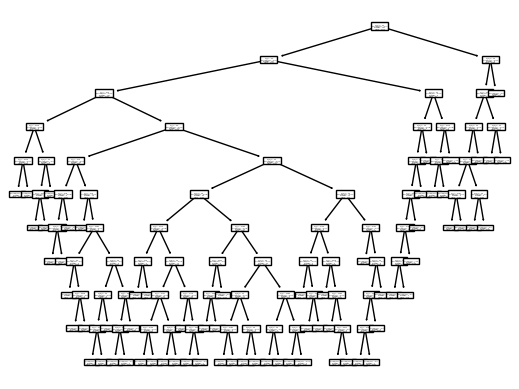

In [16]:
plot_tree(treecv.best_estimator_)

plt.show()

In [17]:
y_hat = treecv.predict(x_test)

print(f"Abs Error: {mean_absolute_error(y_test, y_hat)}")
print(f"Square Error: {mean_squared_error(y_test, y_hat)}")
print(f"r2_score: {r2_score(y_test, y_hat)}")

Scoreset["MAE"].append(mean_absolute_error(y_test, y_hat))
Scoreset["MSE"].append(mean_squared_error(y_test, y_hat))
Scoreset["R2"].append(r2_score(y_test, y_hat))

Scoreset


Abs Error: 0.10025648466699755
Square Error: 0.024491624413300783
r2_score: -0.3002675448209233


{'Names': ['SVR', 'Tree', 'KNN'],
 'MAE': [0.06483634862354092, 0.10025648466699755],
 'MSE': [0.011398105781102645, 0.024491624413300783],
 'R2': [0.39487121109227763, -0.3002675448209233]}

### K Neighbors Regressor

In [18]:
knnthing = KNeighborsRegressor()

knncv = GridSearchCV(estimator=knnthing, param_grid=knnparm, cv = 10)

knncv.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                       20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                       30, 31, 32, 33, 34, 35, 36, 37, 38, 39, ...],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15],
                         'p': [1, 2, 3],
                         'weights': ['uniform', 'distance', None]})

In [19]:
knncv.best_estimator_

KNeighborsRegressor(algorithm='kd_tree', leaf_size=17, n_neighbors=4, p=1,
                    weights='distance')

In [20]:
y_hat = knncv.predict(x_test)

print(f"Abs Error: {mean_absolute_error(y_test, y_hat)}")
print(f"Square Error: {mean_squared_error(y_test, y_hat)}")
print(f"r2_score: {r2_score(y_test, y_hat)}")

Scoreset["MAE"].append(mean_absolute_error(y_test, y_hat))
Scoreset["MSE"].append(mean_squared_error(y_test, y_hat))
Scoreset["R2"].append(r2_score(y_test, y_hat))

Scoreset


Abs Error: 0.06798507036474839
Square Error: 0.00703896504164372
r2_score: 0.6262992752817214


{'Names': ['SVR', 'Tree', 'KNN'],
 'MAE': [0.06483634862354092, 0.10025648466699755, 0.06798507036474839],
 'MSE': [0.011398105781102645, 0.024491624413300783, 0.00703896504164372],
 'R2': [0.39487121109227763, -0.3002675448209233, 0.6262992752817214]}

### Visualizing the prediction

In [21]:
knnpredictioncopyinit = x.copy()

knnpredictioncopy = scaleddf.copy()

#knnpc

predictiontimes = knncv.predict(knnpredictioncopyinit)

knnpredictioncopy["Time"] = predictiontimes

knnpredictioncopy

,Year,Time,PS,Weight_KG,Displacement,CarType_4-door saloon,CarType_Compact,CarType_Convertible,CarType_Coupe,CarType_Estate/wagon,...,Country_Japan,Country_South Korea,Country_United Kingdom,Country_United States,Layout_front engine,Layout_middle engine,Layout_rear engine,Drive_all wheel drive,Drive_front wheel drive,Drive_rear wheel drive
0,0.763636,0.000000,0.368655,0.032031,0.404762,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.745455,0.003996,0.325913,0.000000,0.404762,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.745455,0.012946,0.368655,0.032031,0.404762,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.727273,0.017101,0.458593,0.096092,0.654762,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.709091,0.062810,0.305432,0.000000,0.357143,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,0.690909,0.749560,0.130009,0.379885,0.380952,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
183,0.836364,0.781685,0.152271,0.400384,0.404762,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
184,0.290909,0.890203,0.043633,0.431134,0.595238,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
185,0.290909,0.839015,0.013357,0.414478,0.595238,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [22]:
predictioncopyinvertedinit = fitter.inverse_transform(knnpredictioncopy)

predictioncopyinverted = pd.DataFrame(predictioncopyinvertedinit, columns = scaleddf.columns)

predictioncopyinverted

,Year,Time,PS,Weight_KG,Displacement,CarType_4-door saloon,CarType_Compact,CarType_Convertible,CarType_Coupe,CarType_Estate/wagon,...,Country_Japan,Country_South Korea,Country_United Kingdom,Country_United States,Layout_front engine,Layout_middle engine,Layout_rear engine,Drive_all wheel drive,Drive_front wheel drive,Drive_rear wheel drive
0,2008.0,70.100000,558.0,825.0,3.4,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,2007.0,70.350000,510.0,775.0,3.4,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,2007.0,70.910000,558.0,825.0,3.4,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,2006.0,71.170000,659.0,925.0,5.5,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,2005.0,74.030000,487.0,775.0,3.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,2004.0,117.000000,290.0,1368.0,3.2,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
183,2012.0,119.010000,315.0,1400.0,3.4,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
184,1982.0,125.800000,193.0,1448.0,5.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
185,1982.0,122.597196,159.0,1422.0,5.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


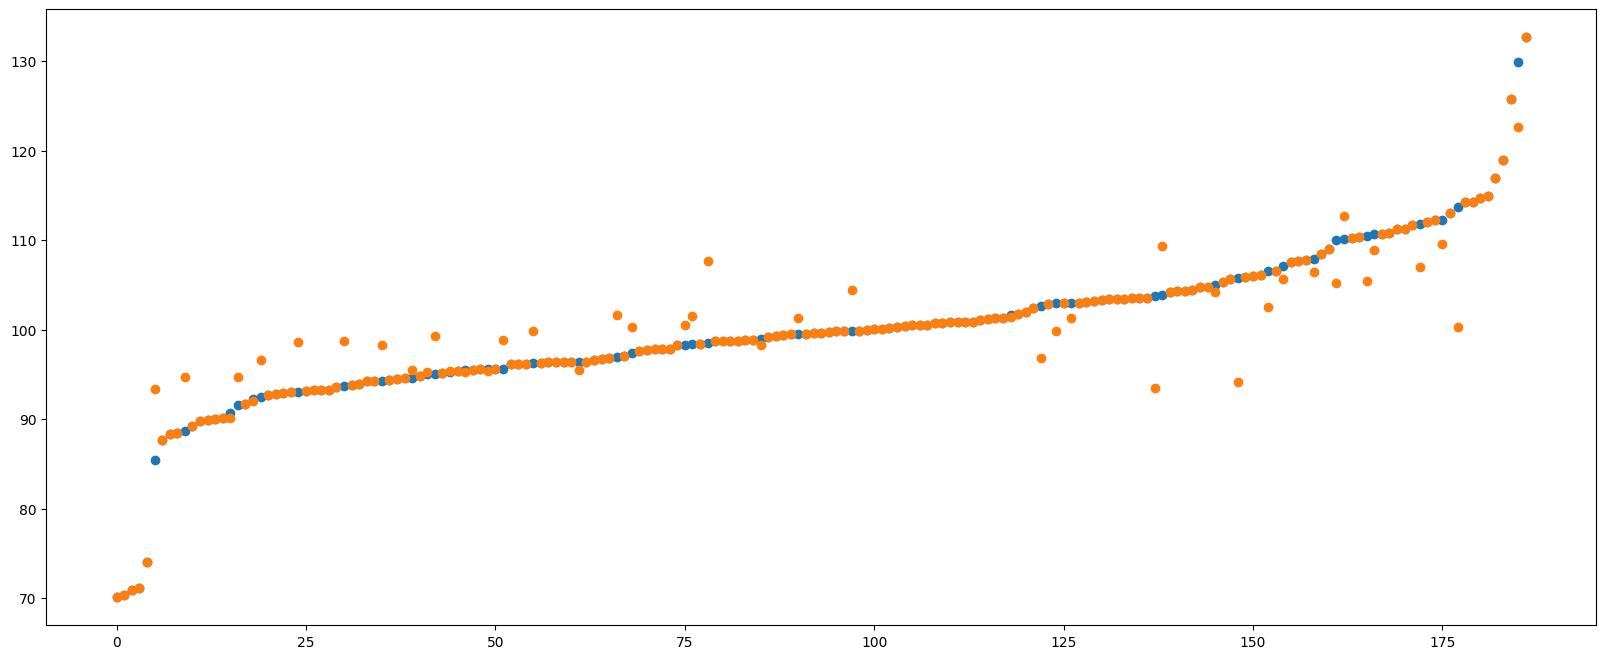

In [23]:
plt.figure(figsize = (20,8))
plt.scatter(x=[n for n in range(0, df.shape[0])], y = df["Time"])
plt.scatter(x=[n for n in range(0, df.shape[0])], y = predictioncopyinverted["Time"])

In [24]:
PredictionComparison = pd.read_csv("CarComparisonChart.csv", header= 1)

PredictionComparison

,Car,Year,Time,PS,Weight_KG,Displacement,Car_type,Country_of_Origin,Engine_Layout,Drivetrain
0,Ford Mustang GTD,2023,132.67,810,1580,5.2,Coupe,United States,front engine,rear wheel drive
1,Porsche 911 GT3 (992),2021,132.67,510,1418,4.0,Coupe,Germany,rear engine,rear wheel drive
2,Porsche 911 GT3 RS (992),2023,132.67,525,1454,4.0,Coupe,Germany,rear engine,rear wheel drive
3,Mercedes-Benz CLK DTM,2004,132.67,582,1678,5.4,Coupe,Germany,front engine,rear wheel drive
4,Chevrolet Corvette Z06 (C8),2022,132.67,679,1654,5.5,Coupe,United States,middle engine,rear wheel drive
5,Chevrolet Corvette ZR1 (C7),2018,132.67,765,1614,6.2,Coupe,United States,front engine,rear wheel drive
6,Ford GT,2004,132.67,550,1538,5.4,Coupe,United States,middle engine,rear wheel drive
7,Ford GT MK2,2017,132.67,656,1385,3.5,Coupe,United States,middle engine,rear wheel drive
8,Nissan GTR Nismo,2015,132.67,600,1720,3.8,Coupe,Japan,front engine,all wheel drive
9,MG XPower SV-R,2004,132.67,385,1580,5.0,Coupe,United Kingdom,front engine,rear wheel drive


The process is the same:
- Drop the name
- Gather dummies (get blank ones for the columns that are missing)
- MinMax Scale it

In [25]:
PredictorNumericals = PredictionComparison[["Year","Time", "PS", "Weight_KG", "Displacement"]]

PredictorNumericals

,Year,Time,PS,Weight_KG,Displacement
0,2023,132.67,810,1580,5.2
1,2021,132.67,510,1418,4.0
2,2023,132.67,525,1454,4.0
3,2004,132.67,582,1678,5.4
4,2022,132.67,679,1654,5.5
5,2018,132.67,765,1614,6.2
6,2004,132.67,550,1538,5.4
7,2017,132.67,656,1385,3.5
8,2015,132.67,600,1720,3.8
9,2004,132.67,385,1580,5.0


In [26]:
predcartypedummies = pd.get_dummies(data = PredictionComparison["Car_type"], prefix = "CarType")
for colname in cartypedummies.columns:
    if colname not in predcartypedummies:
        predcartypedummies[colname] = np.zeros(PredictionComparison.shape[0], dtype = int)

predcartypedummies = predcartypedummies.sort_index(axis = 1)

# -----------------------------------

predcountrydummies = pd.get_dummies(data = PredictionComparison["Country_of_Origin"], prefix = "Country")
for colname in countrydummies.columns:
    if colname not in predcountrydummies:
        predcountrydummies[colname] = np.zeros(PredictionComparison.shape[0], dtype = int)

predcountrydummies = predcountrydummies.sort_index(axis = 1)

# -----------------------------------

predlayoutdummies = pd.get_dummies(data = PredictionComparison["Engine_Layout"], prefix = "Layout")
for colname in layoutdummies.columns:
    if colname not in predlayoutdummies:
        predlayoutdummies[colname] = np.zeros(PredictionComparison.shape[0], dtype = int)

predlayoutdummies = predlayoutdummies.sort_index(axis = 1)

# -----------------------------------

preddrivedummies = pd.get_dummies(data = PredictionComparison["Drivetrain"], prefix = "Drive")
for colname in drivedummies.columns:
    if colname not in preddrivedummies:
        preddrivedummies[colname] = np.zeros(PredictionComparison.shape[0], dtype = int)

preddrivedummies = preddrivedummies.sort_index(axis = 1)

In [27]:
newpreddf = PredictorNumericals.copy()

newpreddf = newpreddf.join(predcartypedummies)

newpreddf = newpreddf.join(predcountrydummies)

newpreddf = newpreddf.join(predlayoutdummies)

newpreddf = newpreddf.join(preddrivedummies)

newpreddf

,Year,Time,PS,Weight_KG,Displacement,CarType_4-door saloon,CarType_Compact,CarType_Convertible,CarType_Coupe,CarType_Estate/wagon,...,Country_Japan,Country_South Korea,Country_United Kingdom,Country_United States,Layout_front engine,Layout_middle engine,Layout_rear engine,Drive_all wheel drive,Drive_front wheel drive,Drive_rear wheel drive
0,2023,132.67,810,1580,5.2,0,0,0,1,0,...,0,0,0,1,1,0,0,0,0,1
1,2021,132.67,510,1418,4.0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
2,2023,132.67,525,1454,4.0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
3,2004,132.67,582,1678,5.4,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
4,2022,132.67,679,1654,5.5,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
5,2018,132.67,765,1614,6.2,0,0,0,1,0,...,0,0,0,1,1,0,0,0,0,1
6,2004,132.67,550,1538,5.4,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
7,2017,132.67,656,1385,3.5,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
8,2015,132.67,600,1720,3.8,0,0,0,1,0,...,1,0,0,0,1,0,0,1,0,0
9,2004,132.67,385,1580,5.0,0,0,0,1,0,...,0,0,1,0,1,0,0,0,0,1


In [28]:
scaledpred = fitter.transform(newpreddf)

scaledpreddf = pd.DataFrame(scaledpred, columns = newpreddf.columns)

scaledpreddf

,Year,Time,PS,Weight_KG,Displacement,CarType_4-door saloon,CarType_Compact,CarType_Convertible,CarType_Coupe,CarType_Estate/wagon,...,Country_Japan,Country_South Korea,Country_United Kingdom,Country_United States,Layout_front engine,Layout_middle engine,Layout_rear engine,Drive_all wheel drive,Drive_front wheel drive,Drive_rear wheel drive
0,1.036364,1.0,0.593054,0.515695,0.619048,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,1.0,0.325913,0.411915,0.476190,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.036364,1.0,0.339270,0.434978,0.476190,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.690909,1.0,0.390027,0.578475,0.642857,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.018182,1.0,0.476402,0.563101,0.654762,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
5,0.945455,1.0,0.552983,0.537476,0.738095,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
6,0.690909,1.0,0.361532,0.488789,0.642857,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
7,0.927273,1.0,0.455922,0.390775,0.416667,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
8,0.890909,1.0,0.406055,0.605381,0.452381,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
9,0.690909,1.0,0.214604,0.515695,0.595238,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [29]:
xpred = scaledpreddf.drop(columns = ["Time"])

xpred

,Year,PS,Weight_KG,Displacement,CarType_4-door saloon,CarType_Compact,CarType_Convertible,CarType_Coupe,CarType_Estate/wagon,CarType_SUV/truck,...,Country_Japan,Country_South Korea,Country_United Kingdom,Country_United States,Layout_front engine,Layout_middle engine,Layout_rear engine,Drive_all wheel drive,Drive_front wheel drive,Drive_rear wheel drive
0,1.036364,0.593054,0.515695,0.619048,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.325913,0.411915,0.476190,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.036364,0.339270,0.434978,0.476190,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.690909,0.390027,0.578475,0.642857,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.018182,0.476402,0.563101,0.654762,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
5,0.945455,0.552983,0.537476,0.738095,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
6,0.690909,0.361532,0.488789,0.642857,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
7,0.927273,0.455922,0.390775,0.416667,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
8,0.890909,0.406055,0.605381,0.452381,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
9,0.690909,0.214604,0.515695,0.595238,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [36]:
finalypred = knncv.predict(xpred)

finalypred

array([0.41413357, 0.37878309, 0.37613286, 0.47951703, 0.43623007,
       0.43278362, 0.46913822, 0.40199497, 0.40550312, 0.59661893,
       0.48636198, 0.53965544])

In [37]:
scaledpreddf["Time"] = finalypred

reinverted = fitter.inverse_transform(scaledpreddf)

preddf = pd.DataFrame(reinverted, columns = scaledpreddf.columns)

preddf

,Year,Time,PS,Weight_KG,Displacement,CarType_4-door saloon,CarType_Compact,CarType_Convertible,CarType_Coupe,CarType_Estate/wagon,...,Country_Japan,Country_South Korea,Country_United Kingdom,Country_United States,Layout_front engine,Layout_middle engine,Layout_rear engine,Drive_all wheel drive,Drive_front wheel drive,Drive_rear wheel drive
0,2023.0,96.012337,810.0,1580.0,5.2,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,2021.0,93.800458,510.0,1418.0,4.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,2023.0,93.634633,525.0,1454.0,4.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,2004.0,100.103381,582.0,1678.0,5.4,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,2022.0,97.394915,679.0,1654.0,5.5,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
5,2018.0,97.179271,765.0,1614.0,6.2,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
6,2004.0,99.453979,550.0,1538.0,5.4,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
7,2017.0,95.252825,656.0,1385.0,3.5,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
8,2015.0,95.472330,600.0,1720.0,3.8,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
9,2004.0,107.430446,385.0,1580.0,5.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [38]:
PredictionComparison["Time"] = preddf["Time"]

PredictionComparison

,Car,Year,Time,PS,Weight_KG,Displacement,Car_type,Country_of_Origin,Engine_Layout,Drivetrain
0,Ford Mustang GTD,2023,96.012337,810,1580,5.2,Coupe,United States,front engine,rear wheel drive
1,Porsche 911 GT3 (992),2021,93.800458,510,1418,4.0,Coupe,Germany,rear engine,rear wheel drive
2,Porsche 911 GT3 RS (992),2023,93.634633,525,1454,4.0,Coupe,Germany,rear engine,rear wheel drive
3,Mercedes-Benz CLK DTM,2004,100.103381,582,1678,5.4,Coupe,Germany,front engine,rear wheel drive
4,Chevrolet Corvette Z06 (C8),2022,97.394915,679,1654,5.5,Coupe,United States,middle engine,rear wheel drive
5,Chevrolet Corvette ZR1 (C7),2018,97.179271,765,1614,6.2,Coupe,United States,front engine,rear wheel drive
6,Ford GT,2004,99.453979,550,1538,5.4,Coupe,United States,middle engine,rear wheel drive
7,Ford GT MK2,2017,95.252825,656,1385,3.5,Coupe,United States,middle engine,rear wheel drive
8,Nissan GTR Nismo,2015,95.472330,600,1720,3.8,Coupe,Japan,front engine,all wheel drive
9,MG XPower SV-R,2004,107.430446,385,1580,5.0,Coupe,United Kingdom,front engine,rear wheel drive
